In [2]:
import time
start = time.perf_counter()

In [13]:
import time
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.random_projection import GaussianRandomProjection
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, auc, confusion_matrix, roc_curve, roc_auc_score, recall_score, f1_score, classification_report, precision_score, homogeneity_score, normalized_mutual_info_score, davies_bouldin_score, mean_squared_error, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, pairwise_distances
from kmodes.kmodes import KModes

In [6]:
N = 5
random_seeds = np.random.randint(0, 903967645, size=N)

In [7]:
phishing_dataset = pd.read_csv('../data/phishing_dataset.csv')
print(phishing_dataset.info())
phishing_dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   index                        11055 non-null  int64
 1   having_IPhaving_IP_Address   11055 non-null  int64
 2   URLURL_Length                11055 non-null  int64
 3   Shortining_Service           11055 non-null  int64
 4   having_At_Symbol             11055 non-null  int64
 5   double_slash_redirecting     11055 non-null  int64
 6   Prefix_Suffix                11055 non-null  int64
 7   having_Sub_Domain            11055 non-null  int64
 8   SSLfinal_State               11055 non-null  int64
 9   Domain_registeration_length  11055 non-null  int64
 10  Favicon                      11055 non-null  int64
 11  port                         11055 non-null  int64
 12  HTTPS_token                  11055 non-null  int64
 13  Request_URL                  11055 non-null  i

,index,having_IPhaving_IP_Address,URLURL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,1,-1,1,1,1,-1,-1,-1,-1,-1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,2,1,1,1,1,1,-1,0,1,-1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,3,1,0,1,1,1,-1,-1,-1,-1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,4,1,0,1,1,1,-1,-1,-1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,5,1,0,-1,1,1,-1,1,1,-1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [8]:
# Check shape of dataset and for null data
print(phishing_dataset.shape)
phishing_dataset.isna().any().any()

(11055, 32)


False

In [9]:
phishing_dataset = phishing_dataset.sample(frac=0.1, random_state=42)

# Separate features and target
train_X = phishing_dataset.drop(columns=['Result', 'Favicon', 'Shortining_Service', 'popUpWidnow', 'double_slash_redirecting'])
train_y = phishing_dataset['Result']

# Normalize the feature data
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(train_X)

# Convert back to DataFrame
train_X = pd.DataFrame(X_scaled, columns=train_X.columns)
print(train_X.shape)

(1106, 27)


In [10]:
dims = list(range(2, 32, 1))

2 :  0.5495161432281859
3 :  0.524670540956455
4 :  0.5174743382684138
5 :  0.5115556848798356
6 :  0.5053196069506524
7 :  0.49351983781480757
8 :  0.46671030966585225
9 :  0.38344748087512753
10 :  0.3454055877145586
11 :  0.3396658396130806
12 :  0.27249559573058035
13 :  0.26364744124885
14 :  0.2587789362579101
15 :  0.2506659101937253
16 :  0.2471442693313937
17 :  0.24390459346073565
18 :  0.22883580862165842
19 :  0.2240638554967732
20 :  0.18459184802947098
21 :  0.1738945941907977
22 :  0.1329057891591477
23 :  0.12837890592106208
24 :  0.12199802765885219
25 :  0.1166192542408587
26 :  0.10326954836387123
27 :  0.07950770280611226
28 :  0.0716504258497115
29 :  0.03330479749948891
30 :  0.021112071695344105
31 :  1.9350929168410323e-28


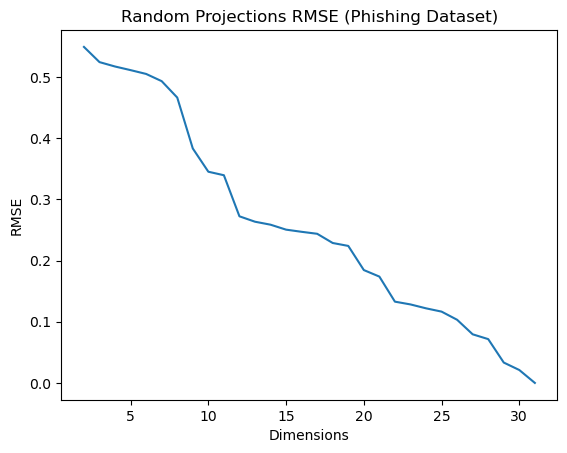

CPU times: user 828 ms, sys: 815 ms, total: 1.64 s
Wall time: 188 ms


In [8]:
%%time

rc_errors = {}

for dim in dims:
    grp = GaussianRandomProjection(n_components=dim, random_state=44)
    x_prime = grp.fit_transform(train_X.values)
    
    # reconstruction
    A = np.linalg.pinv(grp.components_.T)
    reconstructed = np.dot(x_prime, A)
    rc_err = mean_squared_error(train_X.values, reconstructed)    
    rc_errors[dim] = rc_err
    print(dim, ": ", rc_err)
    
plt.figure()
plt.plot(list(rc_errors.keys()), list(rc_errors.values()))
plt.xlabel("Dimensions")
plt.ylabel("RMSE")
plt.title('Random Projections RMSE (Phishing Dataset)')
plt.savefig('../images/phishing-rp-em-rmse.png')
plt.show()

In [11]:
def run_rp(train_X, components, seed):
    grp = GaussianRandomProjection(n_components=components, random_state=seed)
    grp_result = grp.fit_transform(train_X.values)
    return grp_result

# Run RP multiple times with different seeds
rp_results = []
for seed in random_seeds:
    rp_result = run_rp(train_X, components=5, seed=seed)
    rp_results.append(rp_result)

In [14]:
def calculate_distance_preservation(original_data, projected_data):
    original_distances = pairwise_distances(original_data)
    projected_distances = pairwise_distances(projected_data)
    preservation_ratio = np.mean(np.abs(original_distances - projected_distances) / (original_distances + 1e-8))
    return preservation_ratio

distance_preservation_ratios = []
for rp_result in rp_results:
    ratio = calculate_distance_preservation(train_X.values, rp_result)
    distance_preservation_ratios.append(ratio)

# Calculate mean and standard deviation of preservation ratios
mean_ratio = np.mean(distance_preservation_ratios)
std_ratio = np.std(distance_preservation_ratios)

print(f"Mean distance preservation ratio: {mean_ratio}")
print(f"Standard deviation of distance preservation ratio: {std_ratio}")

Mean distance preservation ratio: 0.25579736693372185
Standard deviation of distance preservation ratio: 0.013281864113893375


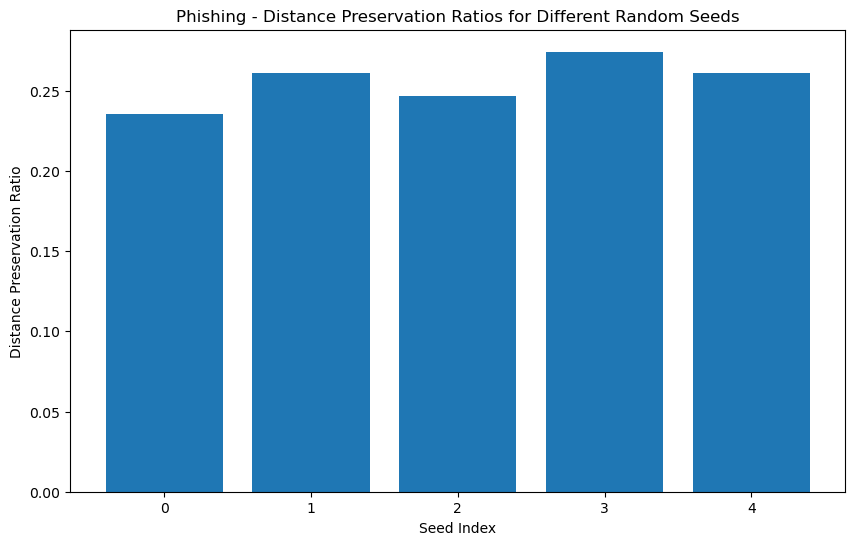

In [17]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(distance_preservation_ratios)), distance_preservation_ratios)
plt.title('Phishing - Distance Preservation Ratios for Different Random Seeds')
plt.xlabel('Seed Index')
plt.ylabel('Distance Preservation Ratio')
plt.savefig('../images/rp_distance_preservation_ratios.png')
plt.show()

In [25]:
%%time

components = 5
grp = GaussianRandomProjection(n_components=components, random_state=42)
grp_result = grp.fit_transform(train_X.values)
for i in range(components):
    field_name = "grp-"+str(i)
    train_X[field_name] = grp_result[:,i]
    phishing_dataset[field_name] = grp_result[:,i]
train_X_grp = grp_result

CPU times: user 2.37 ms, sys: 1.42 ms, total: 3.79 ms
Wall time: 2.73 ms


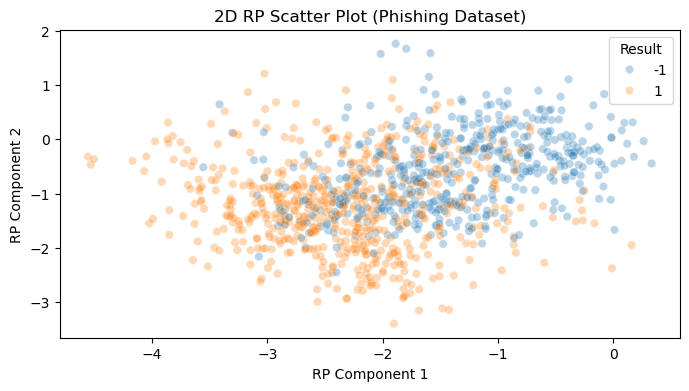

In [26]:
# Plotting the first two PCA components
plt.figure(figsize=(8, 4))
sns.scatterplot(
    x='grp-0', y='grp-1',
    hue='Result',
    palette=sns.color_palette('tab10', 2),
    data=phishing_dataset,
    legend='full',
    alpha=0.3
)
plt.xlabel('RP Component 1')
plt.ylabel('RP Component 2')
plt.title('2D RP Scatter Plot (Phishing Dataset)')
plt.savefig('../images/phishing-nn-rp-2d.png')
plt.show()

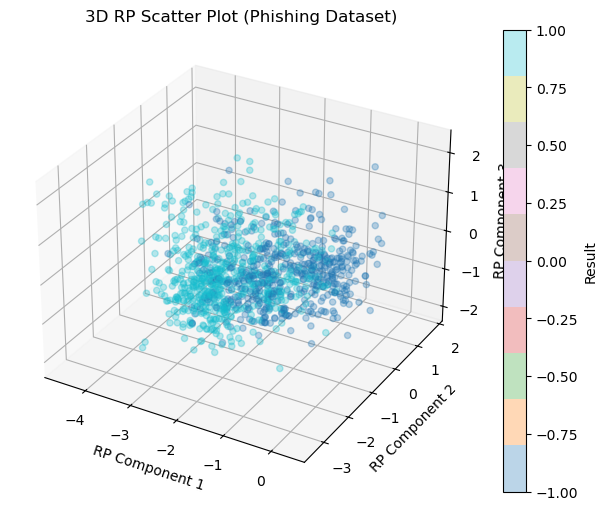

In [27]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    xs=phishing_dataset["grp-0"], 
    ys=phishing_dataset["grp-1"], 
    zs=phishing_dataset["grp-2"], 
    c=phishing_dataset["Result"], 
    cmap='tab10',
    alpha=0.3
)
ax.set_xlabel('RP Component 1')
ax.set_ylabel('RP Component 2')
ax.set_zlabel('RP Component 3')
plt.colorbar(scatter, ax=ax, label='Result')
plt.title('3D RP Scatter Plot (Phishing Dataset)')
plt.savefig('../images/phishing-nn-rp-3d.png')
plt.show()

# Clustering

In [ ]:
%%time

davies_bouldin_scores_KM = {}
adjusted_rand_scores_KM = {}
homogeneity_scores_KM = {}

for cluster in range(2, 31, 1):
    kmodes = KModes(n_clusters=cluster, init='Huang', n_init=10, max_iter=25, random_state=42).fit(train_X_grp)
    label = kmodes.labels_
    
    # Calculate Davies-Bouldin Index
    db_score = davies_bouldin_score(train_X_grp, label)
    # Calculate Adjusted Rand Index
    ari_score = adjusted_rand_score(train_y, label)
    # Calculate Homogeneity Score
    homog_score = homogeneity_score(train_y, label)
    
    davies_bouldin_scores_KM[cluster] = db_score
    adjusted_rand_scores_KM[cluster] = ari_score
    homogeneity_scores_KM[cluster] = homog_score
    
    print(f"For n_clusters={cluster}, The Davies-Bouldin Index is {db_score}")
    print(f"For n_clusters={cluster}, The Adjusted Rand Index is {ari_score}")
    print(f"For n_clusters={cluster}, The homogeneity_score is {homog_score}")

# Plotting Davies-Bouldin Index
plt.figure(figsize=(10, 6))
plt.plot(list(davies_bouldin_scores_KM.keys()), list(davies_bouldin_scores_KM.values()), marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Index")
plt.title("K-Modes - Davies-Bouldin Index for Various Numbers of Clusters - Randomized Projections (Phishing)")
plt.grid(True)
plt.savefig('../images/phishing-rp-kmodes-davies-bouldin-index.png')
plt.show()

For n_clusters=2, The Davies-Bouldin Index is 1.2082494226933684
For n_clusters=2, The Adjusted Rand Index is 0.0005413356699786785
For n_clusters=2, The homogeneity_score is 0.0011003752484417767
For n_clusters=3, The Davies-Bouldin Index is 0.8360427957017668
For n_clusters=3, The Adjusted Rand Index is -0.0008299021327361801
For n_clusters=3, The homogeneity_score is 0.0015093386150727061
For n_clusters=4, The Davies-Bouldin Index is 0.8774238657262248
For n_clusters=4, The Adjusted Rand Index is -0.0002953398541871731
For n_clusters=4, The homogeneity_score is 0.0026073225172507765
For n_clusters=5, The Davies-Bouldin Index is 1.125084881292975
For n_clusters=5, The Adjusted Rand Index is 0.00024243164856826128
For n_clusters=5, The homogeneity_score is 0.0037068604152610037
For n_clusters=6, The Davies-Bouldin Index is 0.9578279313379214
For n_clusters=6, The Adjusted Rand Index is 0.0007834118950032547
For n_clusters=6, The homogeneity_score is 0.004807956966462112
For n_clusters

In [ ]:
# Plotting Adjusted Rand Index
plt.figure(figsize=(8, 4))
plt.plot(list(adjusted_rand_scores_KM.keys()), list(adjusted_rand_scores_KM.values()), marker='o', color='g')
plt.xlabel("Number of Clusters")
plt.ylabel("Adjusted Rand Index")
plt.title("K-Modes Adjusted Rand Index for Various Numbers of Clusters - Randomized Projections (Phishing)")
plt.grid(True)
plt.savefig('../images/phishing-rp-kmodes-adjusted-rand-index.png')
plt.show()

In [ ]:
# Plotting Davies-Bouldin Index, Adjusted Rand Index, and Homogeneity Score together
plt.figure(figsize=(8, 4))
plt.plot(list(davies_bouldin_scores_KM.keys()), list(davies_bouldin_scores_KM.values()), 'b', label='Davies-Bouldin Index', marker='o')
plt.plot(list(adjusted_rand_scores_KM.keys()), list(adjusted_rand_scores_KM.values()), 'g', label='Adjusted Rand Index', marker='x')
plt.plot(list(homogeneity_scores_KM.keys()), list(homogeneity_scores_KM.values()), 'r', label='Homogeneity Score', marker='^')
plt.legend(loc='best')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('K-Modes - Silhouette Coefficient and Homogeneity Score for Various Numbers of Clusters - Randomized Projections (Phishing)')
plt.grid(True)
plt.savefig('../images/phishing-rp-kmodes-silhouette-and-homogeneity.png')
plt.show()

In [ ]:
%%time
silhouette_coeffs_EM = {}
homogeneity_scores_EM = {}
log_likelihood_EM = {}

for cluster in range(2, 11, 1):
    gmm = GaussianMixture(n_components=cluster, n_init=10, max_iter=25, random_state=42).fit(train_X_grp)
    label = gmm.predict(train_X_grp)
    sil_coeff = silhouette_score(train_X_grp, label, metric='euclidean')
    homog_score = homogeneity_score(train_y, label)
    silhouette_coeffs_EM[cluster] = sil_coeff
    homogeneity_scores_EM[cluster] = homog_score
    log_likelihood_EM[cluser] = gmm.score(train_X_ica)
    print(f"For n_clusters={cluster}, The Silhouette Coefficient is {sil_coeff}")
    print(f"For n_clusters={cluster}, The homogeneity_score is {homog_score}")
    print(f"For n_clusters={cluster}, The log_likeliehood score is {log_likelihood_EM[cluster]}")

    
# Plotting Silhouette Coefficients
plt.figure(figsize=(10, 6))
plt.plot(list(silhouette_coeffs.keys()), list(silhouette_coeffs.values()), marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.title("Expectation Maximization - Silhouette Coefficient for Various Numbers of Clusters - Random Projections (Phishing)")
plt.grid(True)
plt.savefig('../images/phishing-rp-em-silhouette-coefficients.png')
plt.show()

In [ ]:
# Plotting Silhouette Coefficient and Homogeneity Score
plt.figure(figsize=(10, 6))
plt.plot(list(silhouette_coeffs.keys()), list(silhouette_coeffs.values()), 'b', label='Silhouette Coefficient', marker='o')
plt.plot(list(homogeneity_scores.keys()), list(homogeneity_scores.values()), 'r', label='Homogeneity Score', marker='x')
plt.legend(loc='best')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Expectation Maximization - Silhouette Coefficient and Homogeneity Score for Various Numbers of Clusters - Random Projections (Phishing)')
plt.grid(True)
plt.savefig('../images/phishing-rp-em-silhouette-homogeneity.png')
plt.show()

In [28]:
kmodes = KModes(n_clusters=5, random_state=42)
kmodes.fit(train_X_grp)
kmodes_labels = kmodes.labels_

In [29]:
train_X['KModes_Cluster'] = kmodes_labels

In [30]:
gmm = GaussianMixture(n_components=5, random_state=42)
gmm.fit(train_X_grp)
gmm_labels = gmm.predict(train_X_grp)

In [31]:
train_X['GMM_Cluster'] = gmm_labels
print(train_X.head())

      index  having_IPhaving_IP_Address  URLURL_Length  Shortining_Service  \
0  0.957376                         0.0            0.0                 1.0   
1  0.681448                         0.0            0.0                 1.0   
2  0.977647                         0.0            1.0                 1.0   
3  0.270498                         1.0            0.0                 1.0   
4  0.808778                         1.0            0.0                 1.0   

   having_At_Symbol  double_slash_redirecting  Prefix_Suffix  \
0               1.0                       1.0            0.0   
1               1.0                       1.0            0.0   
2               1.0                       1.0            0.0   
3               1.0                       1.0            0.0   
4               1.0                       1.0            0.0   

   having_Sub_Domain  SSLfinal_State  Domain_registeration_length  ...  \
0                0.0             0.5                          0.0  ...  

In [32]:
features_to_plot = ['grp-0', 'grp-1']
# Get unique clusters for KMeans and GMM
unique_clusters_kmodes = np.unique(train_X['KModes_Cluster'])
unique_clusters_gmm = np.unique(train_X['GMM_Cluster'])

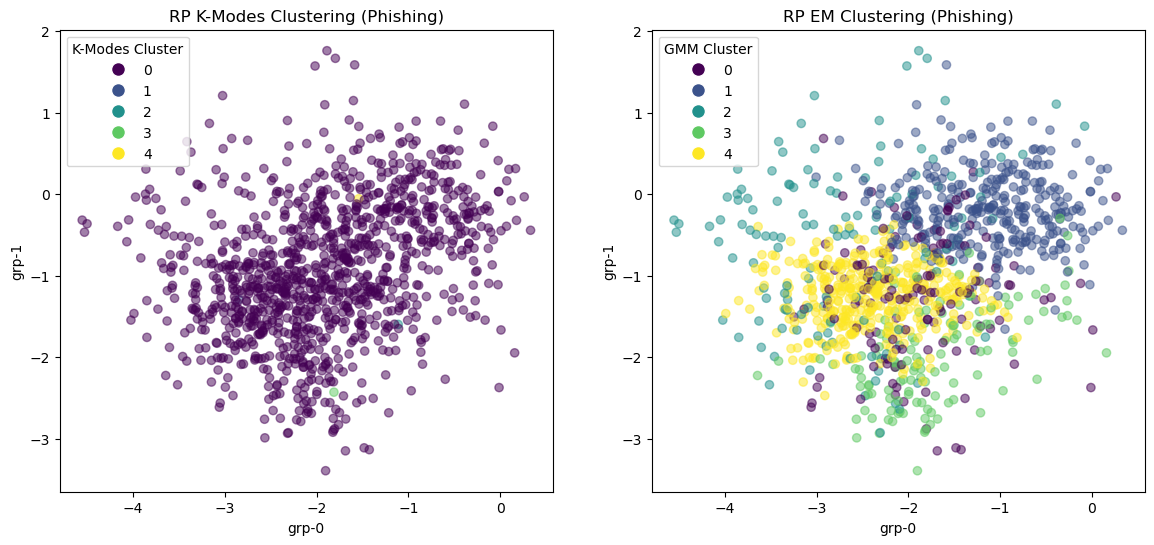

In [33]:
# Create a figure with subplots
plt.figure(figsize=(14, 6))

# Plot K-Means clustering results
plt.subplot(1, 2, 1)
scatter_kmodes = plt.scatter(train_X[features_to_plot[0]], train_X[features_to_plot[1]], c=train_X['KModes_Cluster'], cmap='viridis', alpha=0.5)
plt.title('RP K-Modes Clustering (Phishing)')
plt.xlabel(features_to_plot[0])
plt.ylabel(features_to_plot[1])
handles_kmodes = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_kmodes.cmap(scatter_kmodes.norm(cluster)), markersize=10) for cluster in unique_clusters_kmodes]
plt.legend(handles_kmodes, unique_clusters_kmodes, title='K-Modes Cluster', loc='best')

# Plot GMM clustering results
plt.subplot(1, 2, 2)
scatter_gmm = plt.scatter(train_X[features_to_plot[0]], train_X[features_to_plot[1]], c=train_X['GMM_Cluster'], cmap='viridis', alpha=0.5)
plt.title('RP EM Clustering (Phishing)')
plt.xlabel(features_to_plot[0])
plt.ylabel(features_to_plot[1])
handles_gmm = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_gmm.cmap(scatter_gmm.norm(cluster)), markersize=10) for cluster in unique_clusters_gmm]
plt.legend(handles_gmm, unique_clusters_gmm, title='GMM Cluster', loc='best')

# Save the plot
plt.savefig('../images/phishing-rp-clustering-comparison.png')

# Show the plot
plt.show()

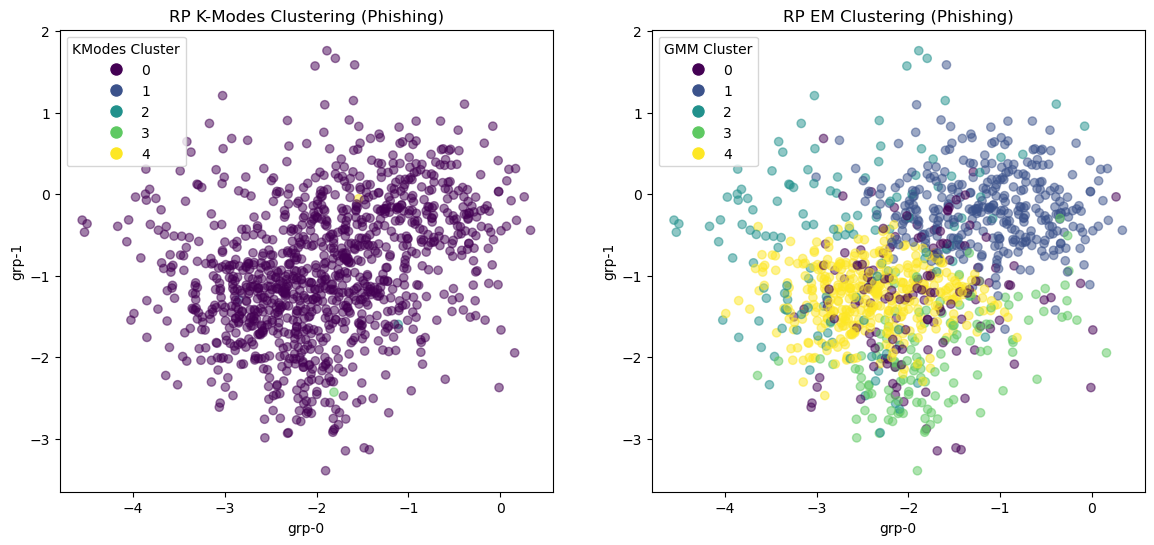

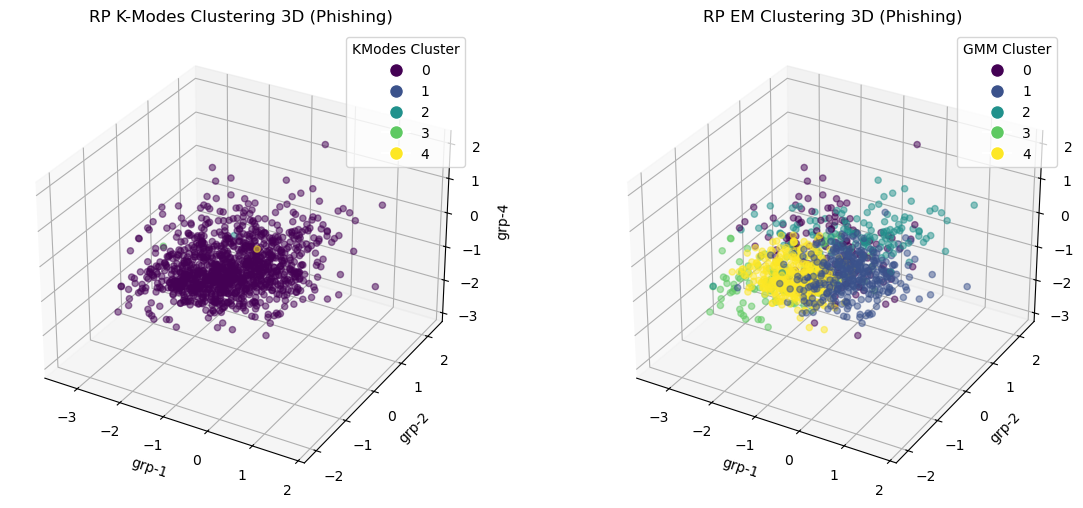

In [34]:
# Define the features you want to plot in 3D
features_to_plot_3d = ['grp-1', 'grp-2', 'grp-4']

# Create a figure for 2D K-Modes and EM clustering results
fig_2d = plt.figure(figsize=(14, 6))

# 2D Plot for K-Modes clustering results
ax1 = fig_2d.add_subplot(121)
scatter_kmodes = ax1.scatter(train_X[features_to_plot[0]], train_X[features_to_plot[1]], c=train_X['KModes_Cluster'], cmap='viridis', alpha=0.5)
ax1.set_title('RP K-Modes Clustering (Phishing)')
ax1.set_xlabel(features_to_plot[0])
ax1.set_ylabel(features_to_plot[1])
handles_kmodes = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_kmodes.cmap(scatter_kmodes.norm(cluster)), markersize=10) for cluster in unique_clusters_kmodes]
ax1.legend(handles_kmodes, unique_clusters_kmodes, title='KModes Cluster', loc='best')

# 2D Plot for EM clustering results
ax2 = fig_2d.add_subplot(122)
scatter_gmm = ax2.scatter(train_X[features_to_plot[0]], train_X[features_to_plot[1]], c=train_X['GMM_Cluster'], cmap='viridis', alpha=0.5)
ax2.set_title('RP EM Clustering (Phishing)')
ax2.set_xlabel(features_to_plot[0])
ax2.set_ylabel(features_to_plot[1])
handles_gmm = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_gmm.cmap(scatter_gmm.norm(cluster)), markersize=10) for cluster in unique_clusters_gmm]
ax2.legend(handles_gmm, unique_clusters_gmm, title='GMM Cluster', loc='best')

fig_2d.savefig('../images/phishing-comparison-rp-2D.png')
plt.show()

# Create a figure for 3D K-Modes and EM clustering results
fig_3d = plt.figure(figsize=(14, 6))

# 3D Plot for K-Modes clustering results
ax1 = fig_3d.add_subplot(121, projection='3d')
scatter_kmodes_3d = ax1.scatter(train_X[features_to_plot_3d[0]], train_X[features_to_plot_3d[1]], train_X[features_to_plot_3d[2]], c=train_X['KModes_Cluster'], cmap='viridis', alpha=0.5)
ax1.set_title('RP K-Modes Clustering 3D (Phishing)')
ax1.set_xlabel(features_to_plot_3d[0])
ax1.set_ylabel(features_to_plot_3d[1])
ax1.set_zlabel(features_to_plot_3d[2], rotation=90)
ax1.legend(handles_kmodes, unique_clusters_kmodes, title='KModes Cluster', loc='best')

# 3D Plot for EM clustering results
ax2 = fig_3d.add_subplot(122, projection='3d')
scatter_gmm_3d = ax2.scatter(train_X[features_to_plot_3d[0]], train_X[features_to_plot_3d[1]], train_X[features_to_plot_3d[2]], c=train_X['GMM_Cluster'], cmap='viridis', alpha=0.5)
ax2.set_title('RP EM Clustering 3D (Phishing)')
ax2.set_xlabel(features_to_plot_3d[0])
ax2.set_ylabel(features_to_plot_3d[1])
ax2.set_zlabel(features_to_plot_3d[2])
ax2.legend(handles_gmm, unique_clusters_gmm, title='GMM Cluster', loc='best')

fig_3d.savefig('../images/phishing-comparison-rp-3D.png')
plt.show()

In [37]:
# Calculate ARI
ari_score = adjusted_rand_score(train_X['KModes_Cluster'], train_X['GMM_Cluster'])
print(f'Phishing Dataset Adjusted Rand Index (ARI) between KMeans and GMM clusters RP: {ari_score}')

# Calculate NMI
nmi_score = normalized_mutual_info_score(train_X['KModes_Cluster'], train_X['GMM_Cluster'])
print(f'Phishing Dataset Normalized Mutual Information (NMI) between KMeans and GMM clusters RP: {nmi_score}')

Phishing Dataset Adjusted Rand Index (ARI) between KMeans and GMM clusters RP: 0.0006034081637167502
Phishing Dataset Normalized Mutual Information (NMI) between KMeans and GMM clusters RP: 0.007835765896388918


# Neural Networks

## K-Modes

In [ ]:
new_kmodes = KModes(n_clusters=12, init='Huang', n_init=10, max_iter=25, random_state=42).fit(train_X_grp)
kmodes_labels = new_kmodes.labels_
kmodes_neural_net = MLPClassifier()
kmodes_neural_net.fit(kmodes_labels, train_y)

In [ ]:
kmodes_train_predictions = kmodes_neural_net.predict(kmodes_labels)
accuracy = accuracy_score(train_y, kmodes_train_predictions)
print(accuracy)
print(classification_report(train_y, kmodes_train_predictions)

In [ ]:
# Ensure train_X_grp and train_y are pandas DataFrames/Series
train_X_kmodes= pd.DataFrame(kmodes_labels)
train_y = pd.Series(train_y)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(train_X_kmodes, train_y):
    strat_train_set = train_X_kmodes.iloc[train_index]
    strat_test_set = train_X_kmodes.iloc[test_index]
    strat_train_labels = train_y.iloc[train_index]
    strat_test_labels = train_y.iloc[test_index]

train_X_kmodes = strat_train_set
test_X_kmodes = strat_test_set
train_y_kmodes = strat_train_labels
test_y_kmodes = strat_test_labels

In [ ]:
kmodes_neural_net = MLPClassifier()
kmodes_neural_net.fit(ktrain_X_kmodes, train_y)

In [ ]:
%%time
# Evaluate on training data
train_predictions_kmodes = kmodes_neural_net.predict(train_X_kmodes)
train_accuracy_kmodes = accuracy_score(train_y_kmodes, train_predictions_kmodes)
train_roc_auc_kmodes = roc_auc_score(train_y_kmodes, train_predictions_kmodes)
train_precision_kmodes = precision_score(train_y_kmodes, train_predictions_kmodes)
train_recall_kmodes = recall_score(train_y_kmodes, train_predictions_kmodes)
train_f1_kmodes = f1_score(train_y_kmodes, train_predictions_kmodes)

print("Training Accuracy K-Modes:", train_accuracy_kmodes)
print("Training ROC AUC Score K-Modes:", train_roc_auc_kmodes)
print("Training Precision K-Modes:", train_precision_kmodes)
print("Training Recall K-Modes:", train_recall_kmodes)
print("Training F1 Score K-Modes:", train_f1_kmodes)
train_report_kmodes = classification_report(train_y_kmodes, train_predictions_kmodes)
print(train_report_kmodes)

# Write to a text file
with open('../results/phishing-nn-kmodes-training_metrics_report.txt', 'w') as file:
    file.write("Training Accuracy K-Modes: " + str(train_accuracy_kmodes) + "\n")
    file.write("Training ROC AUC Score K-Modes: " + str(train_roc_auc_kmodes) + "\n")
    file.write("Training Precision K-Modes: " + str(train_precision_kmodes) + "\n")
    file.write("Training Recall K-Modes: " + str(train_recall_kmodes) + "\n")
    file.write("Training F1 Score K-Modes: " + str(ktrain_f1_kmodes) + "\n")
    file.write("\nClassification Report K-Modes:\n")
    file.write(kmodes_train_report + "\n")

In [ ]:
%%time
# Evaluate testing data
test_predictions_kmodes = neural_net.predict(test_X_kmodes)
test_accuracy_kmodes = accuracy_score(test_y_kmodes, test_predictions_kmodes)
test_roc_auc_kmodes = roc_auc_score(test_y_kmodes, test_predictions_kmodes)
test_precision_kmodes = precision_score(test_y, test_predictions_kmodes)
test_recall_kmodes = recall_score(test_y_kmodes, test_predictions_kmodes)
test_f1_kmodes = f1_score(test_y_kmodes, test_predictions_kmodes)

print("Testing Accuracy:", test_accuracy_kmodes)
print("Testing ROC AUC Score:", test_roc_auc_kmodes)
print("Testing Precision:", test_precision_kmodes)
print("Testing Recall:", test_recall_kmodes)
print("Testing F1 Score:", test_f1_kmodes)
test_report_kmodes = classification_report(test_y_kmodes, test_predictions_kmodes)
print(test_report_kmodes)

# Write to a text file
with open('../results/phishing-nn-kmodes-testing_metrics_report.txt', 'w') as file:
    file.write("Testing Accuracy K-Modes: " + str(test_accuracy_kmodes) + "\n")
    file.write("Testing ROC AUC Score K-Modes: " + str(test_roc_auc_kmodes) + "\n")
    file.write("Testing Precision K-Modes: " + str(test_precision_kmodes) + "\n")
    file.write("Testing Recall K-Modes: " + str(test_recall_kmodes) + "\n")
    file.write("Testing F1 Score K-Modes: " + str(test_f1_kmodes) + "\n")
    file.write("\nClassification Report K-Modes:\n")
    file.write(test_report_kmodes + "\n")

In [ ]:
%%time
fig, ax = plt.subplots(2, 2, figsize=(8, 4))

# Accuracy
ax[0, 0].bar(['Train', 'Test'], [train_accuracy_kmodes, test_accuracy_kmodes], color=['blue', 'orange'])
ax[0, 0].set_title('Accuracy K-Modes (Phishing)')
ax[0, 0].set_ylim([0, 1])
ax[0, 0].set_ylabel('Accuracy Score')

# ROC AUC Score
ax[0, 1].bar(['Train', 'Test'], [train_roc_auc, test_roc_auc], color=['blue', 'orange'])
ax[0, 1].set_title('ROC AUC Score K-Modes (Phishing)')
ax[0, 1].set_ylim([0, 1])
ax[0, 1].set_ylabel('ROC AUC Score')

# Precision
ax[1, 0].bar(['Train', 'Test'], [train_precision, test_precision], color=['blue', 'orange'])
ax[1, 0].set_title('Precision K-Modes (Phishing)')
ax[1, 0].set_ylim([0, 1])
ax[1, 0].set_ylabel('Precision Score')

# Recall
ax[1, 1].bar(['Train', 'Test'], [train_recall, test_recall], color=['blue', 'orange'])
ax[1, 1].set_title('Recall K-Modes (Phishing)')
ax[1, 1].set_ylim([0, 1])
ax[1, 1].set_ylabel('Recall Score')

plt.tight_layout()
fig.savefig('../images/phishing-nn-kmodes-metrics-comparison.png')
plt.show()

# Plotting  ROC Curves
train_fpr_kmodes, train_tpr_kmodes, _ = roc_curve(train_y_kmodes, train_predictions_kmodes)
test_fpr_kmodes, test_tpr_kmodes, _ = roc_curve(test_y_kmodes, test_predictions_kmodes)

plt.figure(figsize=(8, 4))
plt.plot(train_fpr_kmodes, train_tpr_kmodes, label=f'Train ROC (AUC = {auc(train_fpr_kmodes, train_tpr_kmodes):.2f})', color='blue')
plt.plot(test_fpr_kmodes, test_tpr_kmodes, label=f'Test ROC (AUC = {auc(test_fp_kmodesr, test_tpr_kmodes):.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.title('ROC Curve K-Modes (Phishing)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('../images/phishing-nn-kmodes-roc-curve')
plt.show()

In [ ]:
%%time
# Plot and save Training Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 4))
train_cm = confusion_matrix(train_y, train_predictions)
ConfusionMatrixDisplay(train_cm).plot(ax=ax, colorbar=False)
ax.set_title("Training Confusion Matrix")
plt.tight_layout()
plt.savefig('../images/default-payments-nn-ica-training-cm.png')
plt.show()

# Plot and save Test Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 4))
test_cm = confusion_matrix(test_y, test_predictions)
ConfusionMatrixDisplay(test_cm).plot(ax=ax, colorbar=False)
ax.set_title('Test Confusion Matrix ICA (Default Payments)')
plt.tight_layout()
plt.savefig('../images/default-payments-nn-ica-testing-cm.png')
plt.show()

In [ ]:
%%time
# Create a wrapper function for learning_curve to show progress
def learning_curve_with_progress(estimator, X, y, cv, scoring, train_sizes):
    all_train_scores = []
    all_test_scores = []
    for train_size in tqdm(train_sizes, desc='Training progress'):
        _, train_scores, test_scores = learning_curve(estimator, X, y, train_sizes=[train_size], cv=cv, scoring=scoring)
        all_train_scores.append(train_scores)
        all_test_scores.append(test_scores)
    return train_sizes, np.array(all_train_scores).squeeze(), np.array(all_test_scores).squeeze()

train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve_with_progress(neural_net, train_X_ica, train_y, cv=5, scoring='accuracy', train_sizes=train_sizes)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')

plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

plt.title('Learning Curve ICA (Default Payments)')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.savefig('../images/default-payments-nn-ica-learning-curve-training-size.png')
plt.show()

In [ ]:
%%time
param_range = [50, 75, 100]

# Function to calculate validation curve with progress bar
def validation_curve_with_progress(estimator, X, y, param_name, param_range, cv, scoring, n_jobs):
    train_scores = []
    test_scores = []
    for param in tqdm(param_range, desc='Validation progress'):
        train_score, test_score = validation_curve(estimator, X, y, param_name=param_name, param_range=[param], cv=cv, scoring=scoring, n_jobs=n_jobs)
        train_scores.append(train_score)
        test_scores.append(test_score)
    return np.array(train_scores).squeeze(), np.array(test_scores).squeeze()

train_scores, test_scores = validation_curve_with_progress(MLPClassifier(), train_X_ica, train_y, param_name="hidden_layer_sizes", param_range=param_range, cv=5, scoring='accuracy', n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 4))
plt.plot(param_range, train_scores_mean, 'o-', color='r', label="Training score")
plt.plot(param_range, test_scores_mean, 'o-', color='g', label="Cross-validation score")

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')

plt.title('Validation Curve ICA (Default Payments)')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.savefig('../images/default-payments-nn-ica-validation-curve-hidden-layers.png')
plt.show()

In [ ]:
end = time.perf_counter()
print("Time taken: in min", (end - start)/60)